In [1]:
%%capture
#--------------------------------------------------------------------------------------------
# Creating R environment to be executed in Jupyter Notebook
#--------------------------------------------------------------------------------------------
import rpy2.rinterface
from IPython.display import Image
%load_ext rpy2.ipython
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

In [2]:
%%capture
%%R
#--------------------------------------------------------------------------------------------
# Necessary packages loading for R
#--------------------------------------------------------------------------------------------
library(plm) #package for panel regression
library(lmtest) #package for coefficient test to obtain robust standard error like stata
library(glue)
library(dynlm) #package for running time series regression
library(vars) #package for VAR models
library(dplyr) #package for data manipulations

In [3]:
#--------------------------------------------------------------------------------------------
# Necessary packages loading for python
#--------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipystata #package for executing stata code from python

In [4]:
#--------------------------------------------------------------------------------------------
# loading data from github hosted datasource
# Data source : OECD dataset and International Financial Statistics, IMF
#--------------------------------------------------------------------------------------------
df = pd.read_csv("https://raw.githubusercontent.com/htdanil/referenced_to_github/master/G0008_G7_data.csv")
df.head()

,Q,QUARTER,COUNTRY,GDP_DEFLATOR,GDP,TAX,GOVT_CONS,PRIVATE_CONS,INV,SHORT_TERM_INTEREST_RATE
0,1961.25,1961Q1,CANADA,17.7,10168.0,NaN,1646.0,6385.0,2308.0,3.6967
1,1961.50,1961Q2,CANADA,18.2,10392.0,NaN,1671.0,6512.0,2349.0,3.5300
2,1961.75,1961Q3,CANADA,18.6,10670.0,NaN,1752.0,6676.0,2257.0,3.1367
3,1962.00,1962Q4,CANADA,18.9,9881.0,NaN,1595.0,6115.0,2266.0,3.1067
4,1962.25,1962Q1,CANADA,19.4,10158.0,NaN,1625.0,6273.0,2329.0,3.4022


In [5]:
#--------------------------------------------------------------------------------------------
# Deflating nominal variables to real variables using GDP deflator and taking log
#--------------------------------------------------------------------------------------------
df['ly'] = np.log(df['GDP']/df['GDP_DEFLATOR']*100)
df['ltx'] = np.log(df['TAX']/df['GDP_DEFLATOR']*100)
df['lgc'] = np.log(df['GOVT_CONS']/df['GDP_DEFLATOR']*100)
df['lpc'] = np.log(df['PRIVATE_CONS']/df['GDP_DEFLATOR']*100)
df['linv'] = np.log(df['INV']/df['GDP_DEFLATOR']*100)


df['i'] = df['SHORT_TERM_INTEREST_RATE']

In [6]:
%%stata -d df -o stata_df -os
*--------------------------------------------------------------------------------------------
* #Stata environment initiated
*
*
* #encoding string variable to set for panel data
*--------------------------------------------------------------------------------------------
encode COUNTRY, generate(COUNTRY_ID)


*--------------------------------------------------------------------------------------------
*#generating QDATE variable from String quarter variable
*--------------------------------------------------------------------------------------------
gen QDATE = quarterly( QUARTER, "YQ" )
format QDATE %tq


*--------------------------------------------------------------------------------------------
*#setting panel data
*--------------------------------------------------------------------------------------------
xtset COUNTRY_ID QDATE


*--------------------------------------------------------------------------------------------
*#sorting panel data and creating linear and quadratic time variable for later possible use
*--------------------------------------------------------------------------------------------
sort COUNTRY_ID QDATE
bys COUNTRY_ID: gen time1=_n-1
gen time2 = time1^2 


       panel variable:  COUNTRY_ID (strongly balanced)
        time variable:  QDATE, 1961q1 to 2020q4, but with gaps
                delta:  1 quarter



In [7]:
# %%stata -o stata_df -os
# pvarsoc lgc ly ltx, maxlag(2)


Panel vector autoregresssion

GMM Estimation

Final GMM Criterion Q(b) =  8.63e-30
Initial weight matrix: Identity
GMM weight matrix:     Robust
                                                   No. of obs      =       518
                                                   No. of panels   =         7
                                                   Ave. no. of T   =    74.000

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
ly           |
          ly |
         L1. |   .8048831   .1351721     5.95   0.000     .5399506    1.069816
         L2. |   .0628124   .1154472     0.54   0.586      -.16346    .2890849
             |
         lgc |
         L1. |   .1151652   .1339795     0.86   0.390    -.1474298    .3777602
         L2. |  -.0452856   .1169527    -0.39   0.699    -.2745086    .1839375
   

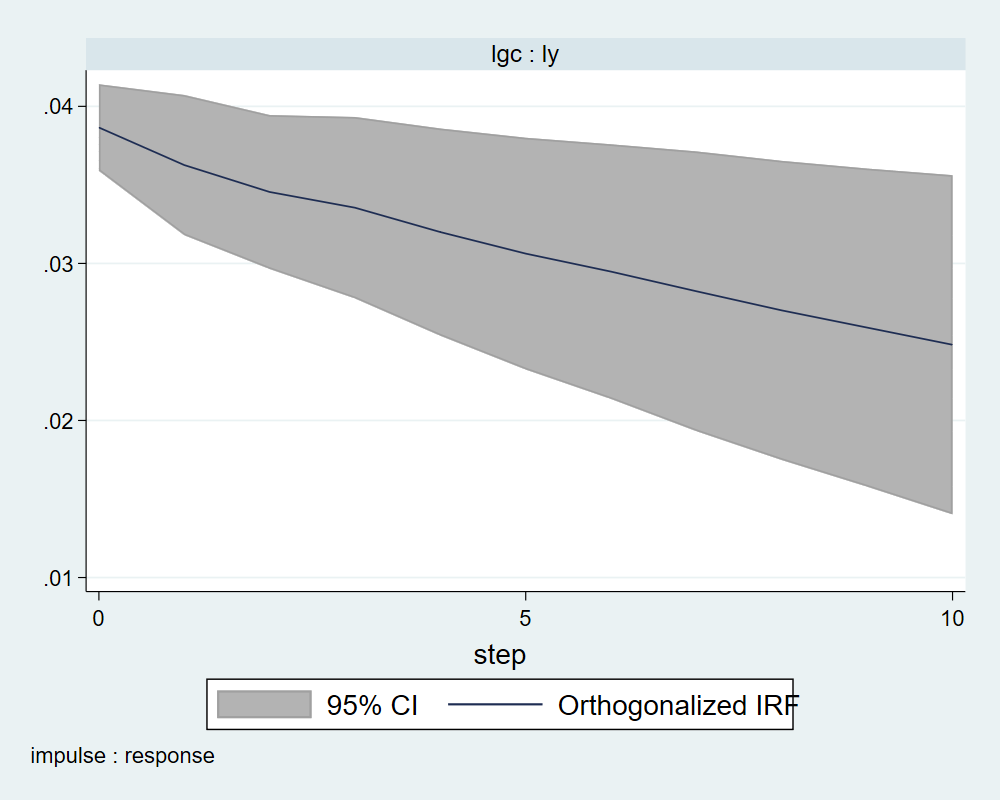

In [8]:
%%stata -o stata_df -os
*--------------------------------------------------------------------------------------------
* #panel var is estimated with log(GDP), lag(Govt. Consumption), and log(tax revenue)
* #stata was struggling to estimate more than 2 lags, therefore, 2 lags are used
*--------------------------------------------------------------------------------------------
pvar ly lgc ltx, lags(2)

*--------------------------------------------------------------------------------------------
* #panel var stability check
*--------------------------------------------------------------------------------------------
pvarstable, graph

*--------------------------------------------------------------------------------------------
* #Impulse responses of panel var model
*--------------------------------------------------------------------------------------------
pvarirf, oirf mc(200) byoption(yrescale) porder(lgc ly ltx) impulse(lgc) response(ly) table

In [30]:
#--------------------------------------------------------------------------------------------
# Calculating GDP to Govt. Consumption spending to calculate fiscal multiplier
#--------------------------------------------------------------------------------------------
df['Y_GC_RATIO'] = df['GDP']/df['GOVT_CONS']
print('Average GDP to Govt. Consumption spending ratio is : ' + str(round(df['Y_GC_RATIO'].mean(),4)))
print('Max GDP to Govt. Consumption spending ratio is : ' + str(round(max(df['Y_GC_RATIO']),4)))
print('Min GDP to Govt. Consumption spending ratio is : ' + str(round(min(df['Y_GC_RATIO']),4)))

Average GDP to Govt. Consumption spending ratio is : 5.3831
Max GDP to Govt. Consumption spending ratio is : 7.176
Min GDP to Govt. Consumption spending ratio is : 4.0592



Panel vector autoregresssion

GMM Estimation

Final GMM Criterion Q(b) =  1.90e-28
Initial weight matrix: Identity
GMM weight matrix:     Robust
                                                   No. of obs      =       531
                                                   No. of panels   =         7
                                                   Ave. no. of T   =    75.857

------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
lgc          |
         lgc |
         L1. |   .8831497    .231764     3.81   0.000     .4289007    1.337399
             |
         lpc |
         L1. |   .9252903   1.182307     0.78   0.434    -1.391989     3.24257
             |
        linv |
         L1. |   .0777928   .0677395     1.15   0.251    -.0549741    .2105597
             |
           i |
         L1. |  -.0006

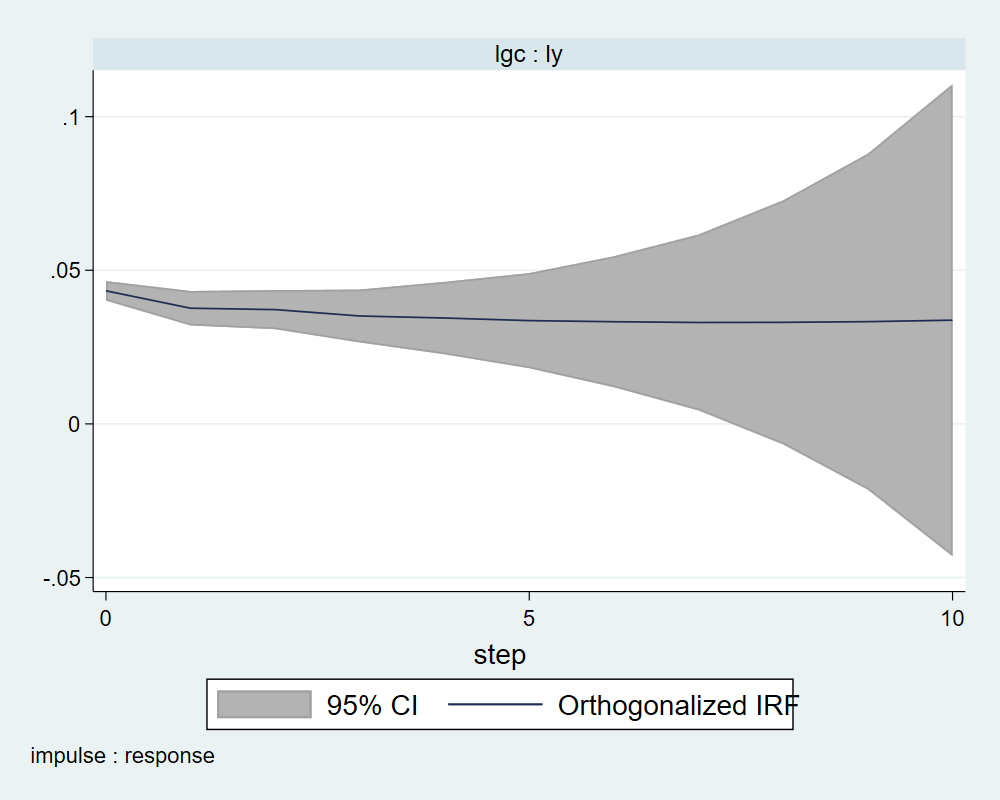

In [10]:
%%stata -o stata_df -os
*--------------------------------------------------------------------------------------------
* #panel var is estimated with log(GDP), lag(Govt. Consumption), and log(tax revenue)
* #stata was struggling to estimate more than 1 lag, therefore, 1 lag are used
*--------------------------------------------------------------------------------------------
pvar lgc lpc linv i ly ltx, lags(1)

*--------------------------------------------------------------------------------------------
* #panel var stability check
*--------------------------------------------------------------------------------------------
pvarstable, graph

*--------------------------------------------------------------------------------------------
* #Impulse responses of panel var model
*--------------------------------------------------------------------------------------------
pvarirf, oirf mc(200) byoption(yrescale) porder(lgc lpc linv i ly ltx) impulse(lgc) response(ly)

In [11]:
#pushing "df" dataframe from python to R environment
%Rpush df 

In [12]:
%%R -w 800 -h 500
#--------------------------------------------------------------------------------------------
# Identifying Govt Consumption shock by first equation of the VAR system (lgc, ly, ltx - with order) for 
# each country. Optimal lag is selected on Schwarz Criterion (SC) with both constant term and trend.
# Then, residuals are extracted as identified Govt Consumption shock.
#--------------------------------------------------------------------------------------------
country_list <- unique(df$COUNTRY) #list of countries i.e. G7 countries

#for loop for each country
for (c in country_list) { 
    # subsetting dataframe based on country's name
    df_subset <- subset(df, COUNTRY==c)
    
    # creating R time series objects for each variable
    ly   <- ts(df_subset$ly, start = c(1961,1), frequency = 4)
    ltx  <- ts(df_subset$ltx, start = c(1961,1), frequency = 4)
    lgc  <- ts(df_subset$lgc, start = c(1961,1), frequency = 4)
    lpc  <- ts(df_subset$lpc, start = c(1961,1), frequency = 4)
    linv  <- ts(df_subset$linv, start = c(1961,1), frequency = 4)
    i  <- ts(df_subset$i, start = c(1961,1), frequency = 4)
    
    #removing NA (blank) rows
    data4var = na.omit(cbind(lgc, ly, ltx))
    
    #optimal lag length selection based on Schwarz Criterion (SC) with both constant term and trend
    var_select <- VARselect(data4var, lag.max = 6, type = 'both')
    optimal_lag <- var_select$selection['SC(n)'][[1]]
    print(paste0('Optimal lag for ', c ,' is ', optimal_lag,'.'))
    
    #creating each country's shock variable
    eval(parse(text=glue("shock_{c} <- dynlm(lgc ~ L(lgc,1:{optimal_lag}) 
                                    + L(ly,1:{optimal_lag}) 
                                    + L(ltx,1:{optimal_lag}) 
                                    + trend(lgc, scale = FALSE))$residuals")))
}

#--------------------------------------------------------------------------------------------
# Combining individual shock variable in a composite dataframe "shock_all"
#--------------------------------------------------------------------------------------------
first_execution_loop = TRUE
for (c in country_list) {
    if (first_execution_loop) {
        eval(parse(text = (glue("shock_all <- cbind(COUNTRY=c,Q=index(shock_{c}),SHOCK=shock_{c})"))))
        first_execution_loop = FALSE
    } else {
        eval(parse(text = (glue('shock_all <- rbind(shock_all, cbind(COUNTRY=c,Q=index(shock_{c}),SHOCK=shock_{c}))'))))
    }
}

#--------------------------------------------------------------------------------------------
# Merging "shock_all" dataframe with original dataframe "df"
#--------------------------------------------------------------------------------------------
df <- merge(x=df, y=shock_all, by = c("COUNTRY","Q"), all.x = T)
df$SHOCK<-as.double(df$SHOCK)

[1] "Optimal lag for CANADA is 1."
[1] "Optimal lag for FRANCE is 4."
[1] "Optimal lag for GERMANY is 4."
[1] "Optimal lag for ITALY is 4."
[1] "Optimal lag for JAPAN is 3."
[1] "Optimal lag for UK is 4."
[1] "Optimal lag for US is 1."


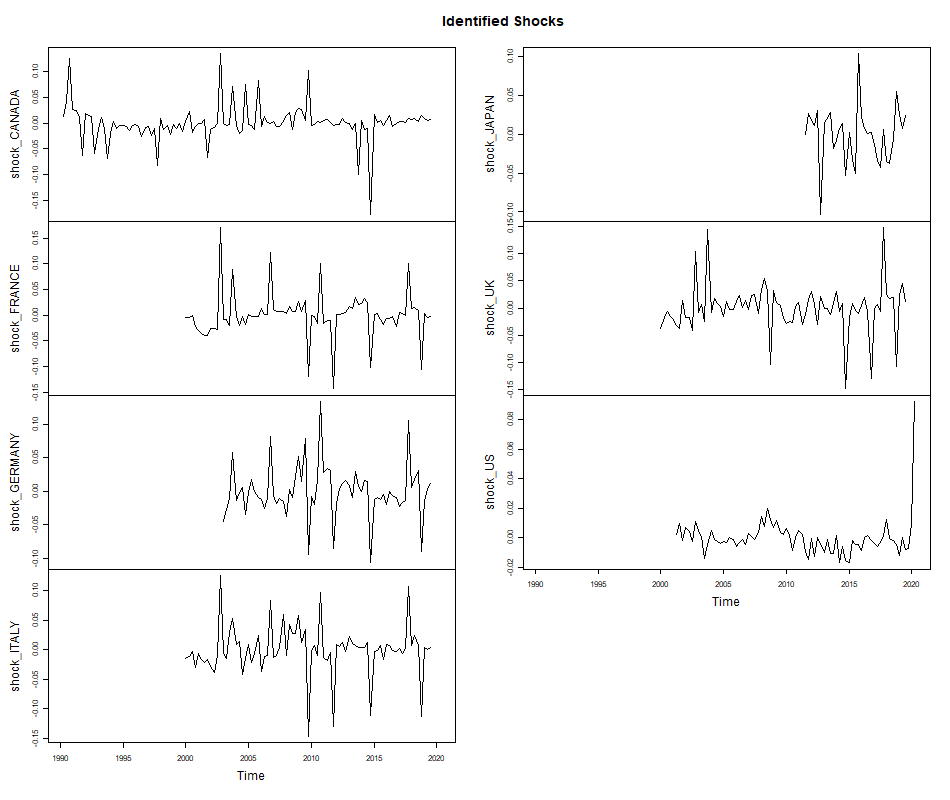

In [13]:
%%R -w 950 -h 800
#--------------------------------------------------------------------------------------------
# Plotting identified shocks for visual inspection
#--------------------------------------------------------------------------------------------
plot(cbind(shock_CANADA,
           shock_FRANCE,
           shock_GERMANY,
           shock_ITALY,
           shock_JAPAN,
           shock_UK,
           shock_US), main='Identified Shocks')

In [14]:
%%R
#----------------------------------------------------------
# Converting string QUARTER variable to R quarter variable
#----------------------------------------------------------
df$QUARTER <- as.yearqtr(df$QUARTER)

#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
b_f <- NULL
se_f <- NULL

horizon = 10

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(0,horizon,1)){
    eval(parse(text = (glue("mod_plm <- plm(lead(ly,{i}) ~ SHOCK  + factor(QUARTER)
                                        + ltx + lpc + linv + i
                                        + lag(ltx) + lag(lpc) + lag(linv) + lag(i),
                                        data = df,
                                        index = c('COUNTRY','QUARTER'),
                                        model = 'within' )")))) 
                                    # index is used to define the panel data
                                    # within model is used for fixed effect
    
    #conducting coefficient test using specific small-sample correction (sss) method
    #to obtain robust Standard Error similar to Stata
    coef<-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss')) 
    
    #creating coefficient and standard error variables
    b_f <- c(b_f, coef['SHOCK','Estimate'] )
    se_f <- c(se_f, coef['SHOCK','Std. Error'])
}

In [15]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
b_f         = %Rget b_f
se_f        = %Rget se_f

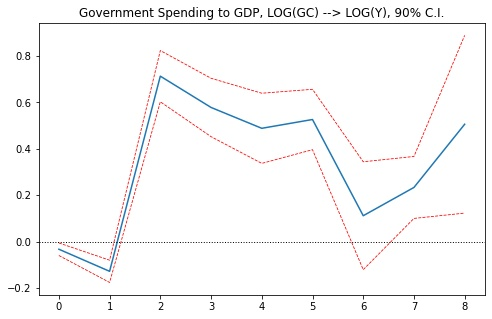

In [16]:
#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------

fig, ax1 = plt.subplots(figsize=(8,5))

horizon = 9

ax1.plot(b_f[:horizon])
ax1.plot((b_f + 1.645 * se_f)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.plot((b_f - 1.645 * se_f)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax1.axhline(0, color='black', linestyle=':', linewidth=1)
ax1.set_title('Government Spending to GDP, LOG(GC) --> LOG(Y), 90% C.I.')
ax1.set_xticks(range(horizon))
plt.show()

In [17]:
%%R
#----------------------------------------------------------------------------------------------------------------
# Creating GDP growth rate and moving average GDP growth rate. Moving average growth rate is constructed by using
# 5 quarters (including 2 previous quarters and 2 post quarters) average growth rates. 
#----------------------------------------------------------------------------------------------------------------
df <- df %>%
    group_by(COUNTRY) %>% #grouping by country
    mutate(y_growth = ly - lag(ly)) %>% #creating new variable of GDP growth rate
    mutate(y_growth_moving_average = (lead(y_growth,2) #creating moving average growth rate
                                      + lead(y_growth,1) 
                                      + y_growth 
                                      + lag(y_growth,1)
                                      + lag(y_growth,2))/5 )

In [18]:
%%R
#----------------------------------------------------------------------------------------------------------------
# Creating SHOCK variables based on boom and recession. To split moving average growth rate into boom and recession
# median of moving average growth rate is used.
#----------------------------------------------------------------------------------------------------------------
median_ygma <- median(df$y_growth_moving_average[df$SHOCK != 'NA'],na.rm = T)
print(paste0("The median moving average GDP growth is ", round(median_ygma,5),"."))

df <- df %>%
    mutate(is_recession = NA) %>% #is_recession binary variable creation
    mutate(is_recession = case_when( #is_recession binary variable value assignment based on median splitting
        y_growth_moving_average <= median_ygma ~ 1,
        y_growth_moving_average > median_ygma ~ 0)) %>%
    mutate(SHOCK_BOOM = SHOCK * (1 - is_recession)) %>% #SHOCK variable for boom is created
    mutate(SHOCK_RECESSION = SHOCK * is_recession) #SHOCK variable for recession is created

[1] "The median moving average GDP growth is 0.00439."


In [19]:
%%R
#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
b_boom <- NULL
se_boom <- NULL

b_recession <- NULL
se_recession <- NULL

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(0,10,1)){
    eval(parse(text = (glue("mod_plm <- plm(lead(ly,{i}) ~ SHOCK_BOOM + SHOCK_RECESSION + factor(QUARTER)
                                        + lgc + lpc + linv + i, 
                                        data = df, 
                                        index =c('COUNTRY','QUARTER'), 
                                        model = 'within' )"))))
    
    coef <-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss'))
    
    b_boom <- c(b_boom, coef['SHOCK_BOOM','Estimate'])
    se_boom <- c(se_boom, coef['SHOCK_BOOM','Std. Error'])
    
    b_recession <- c(b_recession, coef['SHOCK_RECESSION','Estimate'])
    se_recession <- c(se_recession, coef['SHOCK_RECESSION','Std. Error'])
}

In [20]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
b_boom = %Rget b_boom
se_boom = %Rget se_boom

b_recession = %Rget b_recession
se_recession = %Rget se_recession

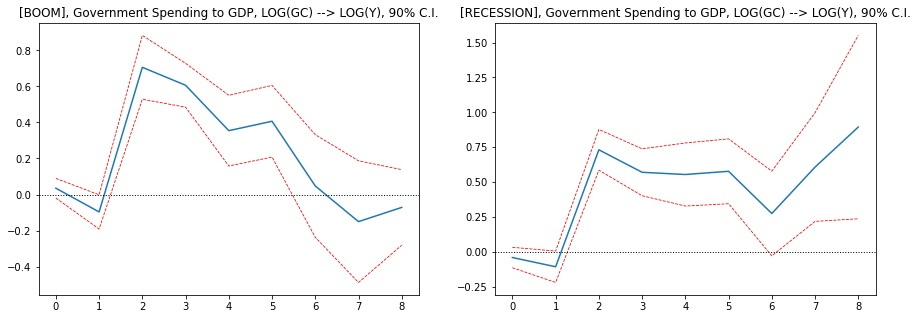

In [21]:
#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------
fig = plt.figure(figsize=(15,5))
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)

horizon = 9

ax2.plot(b_boom[:horizon])
ax2.plot((b_boom + 1.645 * se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.plot((b_boom - 1.645 * se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.axhline(0, color='black', linestyle=':', linewidth=1)
ax2.set_title('[BOOM], Government Spending to GDP, LOG(GC) --> LOG(Y), 90% C.I.')
ax2.set_xticks(range(horizon))

ax3.plot(b_recession[:horizon])
ax3.plot((b_recession + 1.645 * se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.plot((b_recession - 1.645 * se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.axhline(0, color='black', linestyle=':', linewidth=1)
ax3.set_title('[RECESSION], Government Spending to GDP, LOG(GC) --> LOG(Y), 90% C.I.')
ax3.set_xticks(range(horizon))
plt.show()

In [22]:
%%R
#----------------------------------------------------------------------------------------------------------------
# Creating smooth transitioning variable based on moving average GDP growth rate
#----------------------------------------------------------------------------------------------------------------
mn <- mean(df$y_growth_moving_average[df$SHOCK != 'NA'], na.rm = TRUE)
se <- sd(df$y_growth_moving_average[df$SHOCK != 'NA'], na.rm = TRUE)

df$zslack <- (df$y_growth_moving_average - mn)/se
df$g_slack <- exp(-1.5*df$zslack)/(1+exp(-1.5*df$zslack))

df$boom_slack_shock <- df$SHOCK*(1-df$g_slack) #boom
df$recession_slack_shock <- df$SHOCK*df$g_slack #recession

In [23]:
%%R
#----------------------------------------------------------
# creating empty variable
#----------------------------------------------------------
b_boom <- NULL
se_boom <- NULL

b_recession <- NULL
se_recession <- NULL

#----------------------------------------------------------
# loop for constructing series of impulse responses 
# and standard error for confidence interval
#----------------------------------------------------------
for (i in seq(0,10,1)){
    eval(parse(text = (glue("mod_plm <- plm(lead(ly,{i}) ~ boom_slack_shock + recession_slack_shock + factor(QUARTER)
                                         + lgc + lpc + linv + i, 
                                        data = df, 
                                        index =c('COUNTRY','QUARTER'), 
                                        model = 'within' )"))))
    
    coef <-coeftest(mod_plm, vcovHC(mod_plm, type = 'sss'))
    
    b_boom <- c(b_boom, coef['boom_slack_shock','Estimate'])
    se_boom <- c(se_boom, coef['boom_slack_shock','Std. Error'])
    
    b_recession <- c(b_recession, coef['recession_slack_shock','Estimate'])
    se_recession <- c(se_recession, coef['recession_slack_shock','Std. Error'])
}

In [24]:
#----------------------------------------------------------
# exchanging variables from R to Python for graphing
#----------------------------------------------------------
b_boom = %Rget b_boom
se_boom = %Rget se_boom

b_recession = %Rget b_recession
se_recession = %Rget se_recession

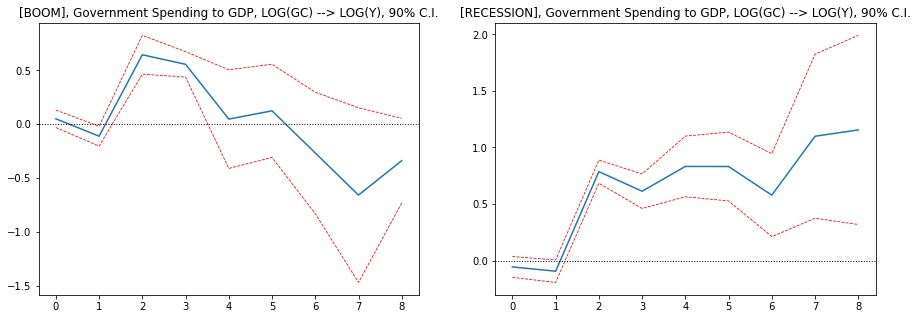

In [25]:
#----------------------------------------------------------
# Graphing of Local Projection impulse responses
#----------------------------------------------------------

fig = plt.figure(figsize=(15,5))
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)

horizon = 9

ax2.plot(b_boom[:horizon])
ax2.plot((b_boom + 1.645 * se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.plot((b_boom - 1.645 * se_boom)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax2.axhline(0, color='black', linestyle=':', linewidth=1)
ax2.set_title('[BOOM], Government Spending to GDP, LOG(GC) --> LOG(Y), 90% C.I.')
ax2.set_xticks(range(horizon))

ax3.plot(b_recession[:horizon])
ax3.plot((b_recession + 1.645 * se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.plot((b_recession - 1.645 * se_recession)[:horizon],color='red',linewidth=0.8,linestyle='--')
ax3.axhline(0, color='black', linestyle=':', linewidth=1)
ax3.set_title('[RECESSION], Government Spending to GDP, LOG(GC) --> LOG(Y), 90% C.I.')
ax3.set_xticks(range(horizon))
plt.show()